# **Fine-tuning Llama 3.2-1B on SMS Spam Classification**


Install the necessary Python packages as outlined below:


In [1]:

!pip install -U bitsandbytes
!pip install -U transformers
!pip install -U accelerate
!pip install -U peft
!pip install -U trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.5 MB/s eta 0:00:00


Next, we need to import all the necessary Python packages and functions.


In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

Load Dataset

In [25]:
import pandas as pd

df = pd.read_parquet("hf://datasets/ucirvine/sms_spam/plain_text/train-00000-of-00001.parquet")

In [26]:
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [27]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

# Display the count for each label
print(label_counts)


label
0    4827
1     747
Name: count, dtype: int64


Map the labels to "ham" and "spam"

In [29]:
# Map the labels to "ham" and "spam"
df['map_label'] = df['label'].map({0: 'ham', 1: 'spam'})

# Display the first few rows to verify the changes
print(df.head())


                                                 sms  label map_label
1                    Ok lar... Joking wif u oni...\n      0       ham
2  Free entry in 2 a wkly comp to win FA Cup fina...      1      spam
3  U dun say so early hor... U c already then say...      0       ham
4  Nah I don't think he goes to usf, he lives aro...      0       ham
5  FreeMsg Hey there darling it's been 3 week's n...      1      spam


We will then split the dataset into the train, eval, and test sets for model training and testing.

We also want to create the “text” column in train and eval sets using the generate_prompt function, which combines the data from the *“sms”* and *“map_label”* columns.

Finally, we’ll create the *“text”* column in the test set using the generate_test_prompt function and the y_true using the “map_label” column. We will use it to generate the model evaluation report, as shown below.

In [44]:
# Split the DataFrame
train_size = 0.8
eval_size = 0.1

# Calculate sizes
train_end = int(train_size * len(df))
eval_end = train_end + int(eval_size * len(df))

# Split the data
X_train = df[:train_end]
X_eval = df[train_end:eval_end]
X_test = df[eval_end:]

# Define the prompt generation functions
def generate_prompt(data_point):
    return f"""
            Classify the text into ham and spam, and return the answer as the corresponding sms label.
text: {data_point["sms"]}
label: {data_point["map_label"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Classify the text into ham, spam and return the answer as the corresponding sms label.
text: {data_point["sms"]}
label: """.strip()

# Generate prompts for training and evaluation data
X_train.loc[:,'text'] = X_train.apply(generate_prompt, axis=1)
X_eval.loc[:,'text'] = X_eval.apply(generate_prompt, axis=1)

# Generate test prompts and extract true labels
y_true = X_test.loc[:,'map_label']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])


<ipython-input-44-dfd14cd778e9>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'text'] = X_train.apply(generate_prompt, axis=1)
<ipython-input-44-dfd14cd778e9>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_eval.loc[:,'text'] = X_eval.apply(generate_prompt, axis=1)


At this point, we want to check the distribution of categories in the train set.

In [45]:
X_train.map_label.value_counts()

,count
map_label,
ham,1457
spam,602


So, next, we want to convert the train and eval set into the Hugging Face datasets.

In [46]:
# Convert to datasets
train_data = Dataset.from_pandas(X_train[["text"]])
eval_data = Dataset.from_pandas(X_eval[["text"]])

In [48]:
train_data['text'][3]

"Classify the text into ham and spam, and return the answer as the corresponding sms label.\ntext: Nah I don't think he goes to usf, he lives around here though\n\nlabel: ham"

In [49]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

# Loading the model and tokenizer

Next, we want to load the Llama-3.2-1b-instruct model in 4-bit quantization to save the GPU memory.

We will then load the tokenizer and set the pad token id.

In [50]:
base_model_name = "meta-llama/Llama-3.2-1B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

tokenizer.pad_token_id = tokenizer.eos_token_id

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

# Model evaluation before fine-tuning

Here, we create the predict function, which will use the text generation pipeline to predict labels from the “text” column. Running the function will return a list of sms spam categories based on various samples in the testing set.

In [51]:
def predict(test, model, tokenizer):
    y_pred = []
    categories = ["ham", "spam"]

    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens=2,
                        temperature=0.1)

        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()

        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred

y_pred = predict(X_test, model, tokenizer)

100%|██████████| 258/258 [00:29<00:00,  8.87it/s]


After, we create the evaluate function that will use the predicted labels and true labels to calculate the overall accuracy of the model and the accuracy per category, generate a classification report, and print out a confusion matrix. Running the function will give us a detailed model evaluation summary.

In [53]:
def evaluate(y_true, y_pred):
    labels = ["ham", "spam"]
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

evaluate(y_true, y_pred)

Accuracy: 0.713
Accuracy for label ham: 0.968
Accuracy for label spam: 0.042

Classification Report:
              precision    recall  f1-score   support

         ham       0.73      0.97      0.83       187
        spam       0.43      0.04      0.08        71

   micro avg       0.72      0.71      0.72       258
   macro avg       0.58      0.51      0.45       258
weighted avg       0.64      0.71      0.62       258


Confusion Matrix:
[[181   4]
 [ 68   3]]


# Building the model

When building the model, we start by extracting the linear module names from the model using the bits and bytes library.

We then configure LoRA using the target modules, task type, and other arguments before setting up training arguments.

We will then create the model trainer using training arguments, a model, a tokenizer, a LoRA configuration, and a dataset.

In [54]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)
modules = find_all_linear_names(model)
modules

['up_proj', 'q_proj', 'down_proj', 'v_proj', 'k_proj', 'gate_proj', 'o_proj']

In [56]:
output_dir="llama-3.2-fine-tuned-model"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    logging_steps=1,
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    # report_to="wandb",                  # report metrics to w&b
    eval_strategy="steps",              # save checkpoint every epoch
    eval_steps = 0.2
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=512,
    packing=False,
    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:327: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pass

Map:   0%|          | 0/2059 [00:00<?, ? examples/s]

Map:   0%|          | 0/257 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


# Model training

In [57]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
52,1.882100,2.386091
104,2.411900,2.267692
156,2.251400,2.201486
208,2.563700,2.160429


TrainOutput(global_step=257, training_loss=2.2160927725209336, metrics={'train_runtime': 591.6501, 'train_samples_per_second': 3.48, 'train_steps_per_second': 0.434, 'total_flos': 630521584742400.0, 'train_loss': 2.2160927725209336, 'epoch': 0.9985429820301117})

We can then save both the model adapter and tokenizer locally. In the next section, we will use this to merge the adopter with the base model.

In [58]:
# Save trained model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-3.2-fine-tuned-model/tokenizer_config.json',
 'llama-3.2-fine-tuned-model/special_tokens_map.json',
 'llama-3.2-fine-tuned-model/tokenizer.json')

# **Testing model after fine-tuning**

Now comes the most crucial part. Will our model perform better after fine-tuning it, or will it get worse? To find out, we must run the 'predict' function on the test set and then the 'evaluate' function to generate a model evaluation report.

In [59]:
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

  0%|          | 0/258 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 258/258 [00:48<00:00,  5.30it/s]

Accuracy: 0.984
Accuracy for label ham: 0.989
Accuracy for label spam: 0.972

Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       187
        spam       0.97      0.97      0.97        71

    accuracy                           0.98       258
   macro avg       0.98      0.98      0.98       258
weighted avg       0.98      0.98      0.98       258


Confusion Matrix:
[[185   2]
 [  2  69]]


In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Assuming y_true and y_pred are your true and predicted labels
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, pos_label='spam')

# Calculate recall
recall = recall_score(y_true, y_pred, pos_label='spam')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, pos_label='spam')

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9845
Precision: 0.9718
Recall: 0.9718
F1 Score: 0.9718


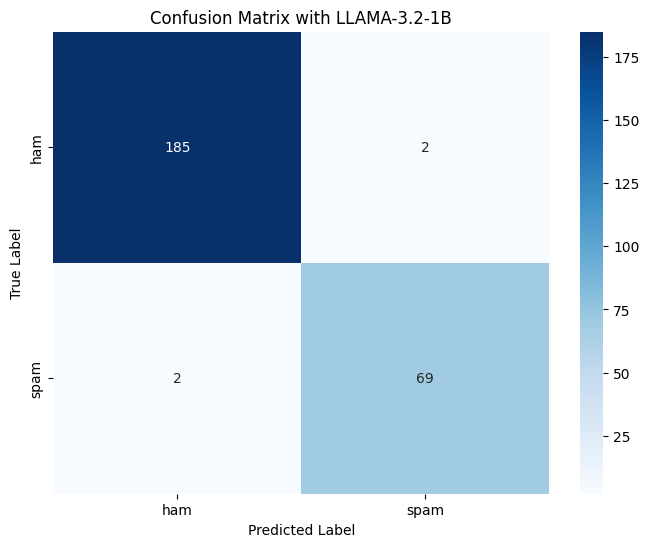

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['ham', 'spam'])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with LLAMA-3.2-1B')
plt.show()


We can now save the model and tokenizer locally.

In [ ]:
model_dir = "Llama-3.2-1B"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

And then push the model and tokenizer to the Hugging Face Hub.

In [ ]:
model.push_to_hub(model_dir, use_temp_dir=False)
tokenizer.push_to_hub(model_dir, use_temp_dir=False)

This will create the repository on Hugging Face and push all the model and tokenizer files.


